# Beta Bank Churn Prediction

**Goal:** The goal of this project is to build a predictive model capable of identifying customers likely to churn, allowing the bank to prioritize targeted retention strategies.
F1 (≥ 0.59) 

Specific goal: F1 score of at least 0.59

**Contents:** Data preparation, preprocessing, class_weight RF, manual oversampling RF, model selection, final test, plots, threshold tuning.

In [1]:
# Imports

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

In [2]:
# Load Data
df = pd.read_csv('/datasets/Churn.csv')
print('Loaded:', df.shape)
display(df.head(3))

Loaded: (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


## Exploratory Data Analysis (EDA)
Inspect missing values, class balance, and basic distributions.

In [3]:
#EDA basics
display(df.info())
display(df.describe().T)
print('\nMissing values:'); print(df.isna().sum())
print('\nClass distribution:'); print(df['Exited'].value_counts()); print('Churn rate:', df['Exited'].mean())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48



Missing values:
RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Class distribution:
0    7963
1    2037
Name: Exited, dtype: int64
Churn rate: 0.2037


## Preprocessing and train/val/test split
Drop identifiers, split stratified into train/val/test (60/20/20). Build preprocessors for numeric and categorical features.

In [4]:
#Split & preprocessing
df_model = df.drop(columns=['RowNumber','CustomerId','Surname'], errors='ignore')
y = df_model['Exited']
X = df_model.drop(columns=['Exited'])

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

print('Train/Val/Test:', X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (6000, 10) (2000, 10) (2000, 10)


## Baseline models (train on training set, evaluate on validation)

In [5]:
#Eval helper
def eval_and_print(model, X, y, label):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1] if hasattr(model, 'predict_proba') else None
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba) if y_proba is not None else float('nan')
    print(f"\n{label} -- F1: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y, y_pred, digits=4))
    print('Confusion matrix:\n', confusion_matrix(y, y_pred))
    return f1, auc, y_pred, y_proba

In [6]:
#Approach A — class_weight RF
rf_cw = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])
rf_cw.fit(X_train, y_train)
f1_cw_val, auc_cw_val, _, _ = eval_and_print(rf_cw, X_val, y_val, 'RF class_weight (validation)')


RF class_weight (validation) -- F1: 0.5486, AUC: 0.8532
              precision    recall  f1-score   support

           0     0.8680    0.9699    0.9161      1593
           1     0.7818    0.4226    0.5486       407

    accuracy                         0.8585      2000
   macro avg     0.8249    0.6962    0.7324      2000
weighted avg     0.8504    0.8585    0.8413      2000

Confusion matrix:
 [[1545   48]
 [ 235  172]]


In [7]:
#Approach B — Manual oversampling on training set
train_df = X_train.copy()
train_df['Exited'] = y_train

n_major = (train_df['Exited'] == 0).sum()
minority_up = train_df[train_df['Exited'] == 1].sample(n_major, replace=True, random_state=42)
train_bal = pd.concat([train_df[train_df['Exited'] == 0], minority_up], ignore_index=True).sample(frac=1.0, random_state=42)

X_train_bal = train_bal.drop(columns='Exited')
y_train_bal = train_bal['Exited']

rf_over = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42))])
rf_over.fit(X_train_bal, y_train_bal)
f1_over_val, auc_over_val, _, _ = eval_and_print(rf_over, X_val, y_val, 'Manual Oversampling + RF (validation)')


Manual Oversampling + RF (validation) -- F1: 0.6180, AUC: 0.8551
              precision    recall  f1-score   support

           0     0.9213    0.8456    0.8818      1593
           1     0.5428    0.7174    0.6180       407

    accuracy                         0.8195      2000
   macro avg     0.7320    0.7815    0.7499      2000
weighted avg     0.8443    0.8195    0.8281      2000

Confusion matrix:
 [[1347  246]
 [ 115  292]]


## Model selection and final evaluation
Choose the model with better validation F1, retrain on train+val, evaluate on the test set.

In [8]:
#Select best by validation F1 and train on train+val
chosen = 'OVER' if f1_over_val >= f1_cw_val else 'CW'
print('Chosen model:', chosen)

comb = X_trainval.copy()
comb['Exited'] = y_trainval

if chosen == 'OVER':
    n_major = (comb['Exited'] == 0).sum()
    minority_up = comb[comb['Exited'] == 1].sample(n_major, replace=True, random_state=42)
    comb_bal = pd.concat([comb[comb['Exited'] == 0], minority_up], ignore_index=True).sample(frac=1.0, random_state=42)
    X_comb = comb_bal.drop(columns='Exited'); y_comb = comb_bal['Exited']
    final_model = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42))])
else:
    X_comb = comb.drop(columns='Exited'); y_comb = comb['Exited']
    final_model = Pipeline([('prep', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])

final_model.fit(X_comb, y_comb)

y_pred_test = final_model.predict(X_test)
y_proba_test = final_model.predict_proba(X_test)[:,1]
print(f"TEST (thr=0.50) -- F1: {f1_score(y_test, y_pred_test):.4f}, AUC: {roc_auc_score(y_test, y_proba_test):.4f}")
print(classification_report(y_test, y_pred_test, digits=4))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))

Chosen model: OVER
TEST (thr=0.50) -- F1: 0.6000, AUC: 0.8634
              precision    recall  f1-score   support

           0     0.9193    0.8293    0.8719      1593
           1     0.5169    0.7150    0.6000       407

    accuracy                         0.8060      2000
   macro avg     0.7181    0.7721    0.7360      2000
weighted avg     0.8374    0.8060    0.8166      2000

Confusion matrix:
 [[1321  272]
 [ 116  291]]


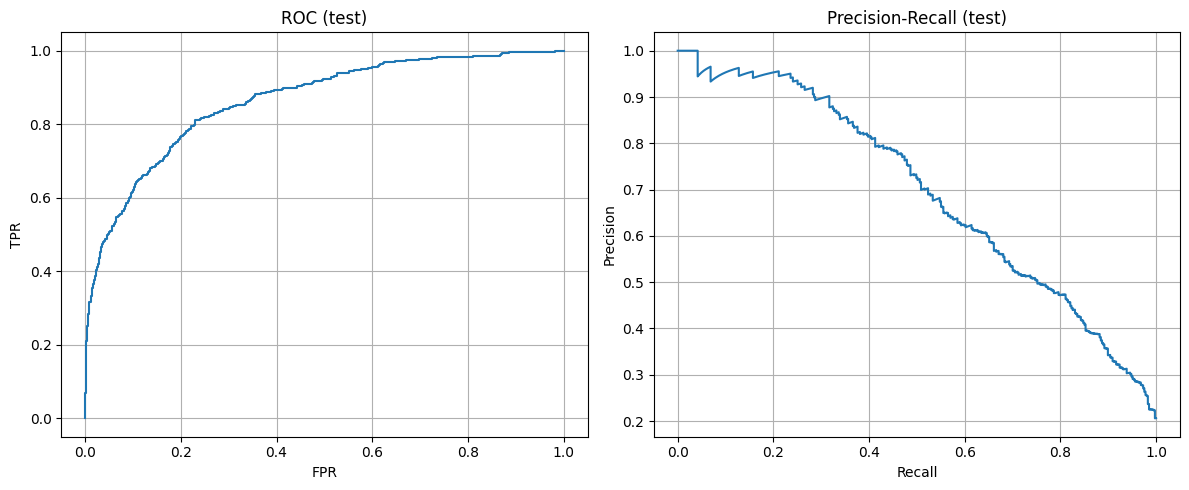

In [9]:
# ROC & PR curves
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
prec, rec, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(fpr, tpr); plt.title('ROC (test)'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(rec, prec); plt.title('Precision-Recall (test)'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.grid(True)
plt.tight_layout(); plt.show()

### Observations

The ROC curve shows that the model has strong discriminative power (AUC ≈ 0.85), while the precision–recall curve indicates that it performs significantly better than random guessing on the minority class. Precision remains high at lower recall levels, which is desirable in churn prediction scenarios where targeting fewer, high-risk customers is often more cost-effective.


In [10]:
#Threshold optimization for F1
thresholds = np.linspace(0, 1, 200)
f1s = [f1_score(y_test, (y_proba_test >= t).astype(int)) for t in thresholds]
best_t = thresholds[int(np.argmax(f1s))]; best_f1 = max(f1s)
print(f'Best threshold: {best_t:.3f} | Best F1: {best_f1:.4f}')

y_best = (y_proba_test >= best_t).astype(int)
print('\nClassification report @ best threshold:')
print(classification_report(y_test, y_best, digits=4))

Best threshold: 0.558 | Best F1: 0.6254

Classification report @ best threshold:
              precision    recall  f1-score   support

           0     0.9080    0.8927    0.9003      1593
           1     0.6060    0.6462    0.6254       407

    accuracy                         0.8425      2000
   macro avg     0.7570    0.7694    0.7629      2000
weighted avg     0.8466    0.8425    0.8444      2000



## Conclusion

**Model Performance**

Two approaches were explored to address the class imbalance:

* A class-weighted Random Forest, and
* A Random Forest with manual oversampling of the minority class.

After evaluating both on the validation set, the manual oversampling model achieved the best performance and was selected for final testing.

* AUC (ROC): 0.8634 → strong ability to distinguish between churners and non-churners.
* F1 Score (threshold 0.50): 0.6000 and F1 Score (optimal threshold 0.558): 0.6254. Good balance between precision and recall for churners.
*Precision (churn): 0.606 and Recall (churn): 0.646 at the optimized threshold.
*The Precision–Recall curve remains well above the baseline, and the ROC curve shows strong separability.

**Business Implications**

* The model can identify about 65% of churners while maintaining a 60% precision rate.
This means most customers flagged as likely churners truly are at risk, making retention campaigns more cost-effective.
* The AUC of 0.86 indicates strong ranking power, meaning the model effectively prioritizes customers based on their churn risk.
* Adjusting the classification threshold allows the business to trade off precision vs. recall, depending on budget or retention capacity.